In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [24]:
!unzip -q /content/face_classification.zip -d /content/dataset

data_dir = "/content/dataset/face_classification"   # ✅ Correct path
img_size = 100   # Resize all faces to 100x100
haar_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

In [25]:
def load_data(data_dir, img_size):
    X, y = [], []
    for label, folder in enumerate(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = cv2.imread(file_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                # Detect face(s)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
                if len(faces) > 0:
                    (x, y_, w, h) = faces[0]   # take first detected face
                    face = gray[y_:y_+h, x:x+w]
                else:
                    face = gray  # fallback: whole image

                face = cv2.resize(face, (img_size, img_size))
                X.append(face)
                y.append(label)
            except Exception as e:
                print("Error loading:", file_path, e)
    return np.array(X), np.array(y)

X, y = load_data(data_dir, img_size)
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (165, 100, 100) (165,)


In [26]:
X = X / 255.0   # normalize
X = X.reshape(-1, img_size, img_size, 1)  # add channel dim
y = to_categorical(y, 2)  # binary classification → 2 classes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (132, 100, 100, 1) Test shape: (33, 100, 100, 1)


In [27]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,352,770 (16.60 MB)

 Trainable params: 4,352,770 (16.60 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.4460 - loss: 0.8019 - val_accuracy: 0.4815 - val_loss: 0.6912
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.6160 - loss: 0.6579 - val_accuracy: 0.5556 - val_loss: 0.6807
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.6805 - loss: 0.6120 - val_accuracy: 0.5926 - val_loss: 0.6592
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 335ms/step - accuracy: 0.7152 - loss: 0.5873 - val_accuracy: 0.7037 - val_loss: 0.6347
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 584ms/step - accuracy: 0.7784 - loss: 0.5357 - val_accuracy: 0.5556 - val_loss: 0.7484
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step - accuracy: 0.7159 - loss: 0.4848 - val_accuracy: 0.6667 - val_loss: 0.6443
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.8526 - loss: 0.4424 - val_accuracy: 0.5926 - val_loss: 0.8104
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.8727 - loss: 0.3048 - val_accuracy: 0.6296 - val_loss:

In [29]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6326 - loss: 0.6622 
Test Accuracy: 63.64%


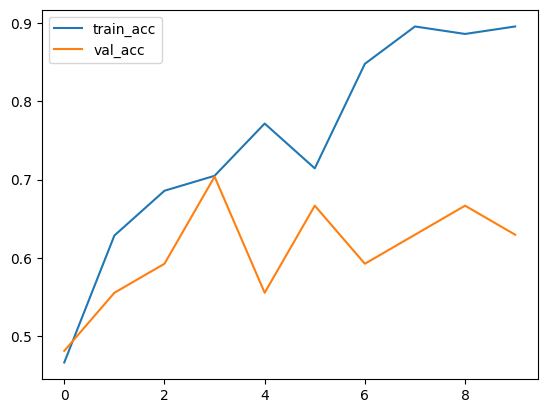

In [30]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


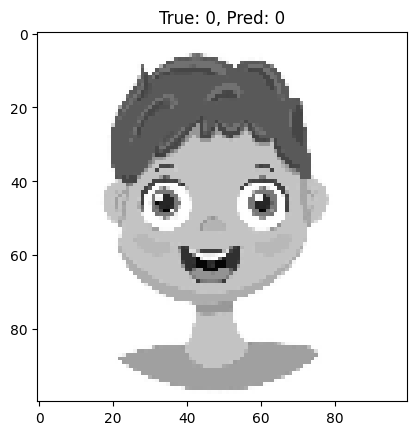

In [31]:
import random
idx = random.randint(0, len(X_test)-1)
sample_img = X_test[idx].reshape(img_size, img_size)
true_label = np.argmax(y_test[idx])
pred_label = np.argmax(model.predict(X_test[idx].reshape(1,img_size,img_size,1)))

plt.imshow(sample_img, cmap='gray')
plt.title(f"True: {true_label}, Pred: {pred_label}")
plt.show()